# Predicting ADR Fluctuations with LSTM

In this example, the LSTM model is used to forecast ADR on the hotel cancellation datasets as provided by Antonio, Almeida and Nunes (2019). Attributions provided below.

#### Attributions

The below code uses the LSTM model from the TensorFlow library, of which the original authors **(Copyright 2019 The TensorFlow Authors)** have made available under the Apache 2.0 license. Modifications have been made where appropriate for conducting analysis on the dataset specific to this example.

The data used in this example is sourced from [Antonio, Almeida and Nunes (2019)](https://www.sciencedirect.com/science/article/pii/S2352340918315191).

The below work and findings are not endorsed by the original authors in any way.

#### Apache 2.0 License

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Python version

In [2]:
from platform import python_version
print(python_version())

3.8.10


## Import Libraries

In [3]:
import tensorflow as tf
print(tf.__version__)

2023-04-16 21:15:05.031111: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 21:15:05.090525: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 21:15:05.091323: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 21:15:06.175556: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0


In [4]:
tf.random.set_seed(1234)

In [5]:
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf

from math import sqrt
from numpy.random import seed
seed(1)
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM


dtypes = {
        'IsCanceled':                                    'float64',
        'LeadTime':                                          'float64',
        'StaysInWeekendNights':                                     'float64',
        'StaysInWeekNights':                                     'float64',
        'Adults':                            'float64',
        'Children':                            'float64',
        'Babies':                                  'float64',
        'Meal':                                    'category',
        'Country':                                               'category',
        'MarketSegment':                                    'category',
        'DistributionChannel':                                       'category',
        'IsRepeatedGuest':                               'float64',
        'PreviousCancellations':                                    'float64',
        'PreviousBookingsNotCanceled':                          'float64',
        'ReservedRoomType':                                             'category',
        'AssignedRoomType':                                            'category',
        'BookingChanges':                                                'float64',
        'DepositType':                                              'category',
        'Agent':                                              'category',
        'Company':                                 'category',
        'DaysInWaitingList':                                           'float64',
        'CustomerType':                                           'category',
        'ADR':                                          'float64',
        'RequiredCarParkingSpaces':                                      'float64',
        'TotalOfSpecialRequests':                                              'float64',
        'ReservationStatus':                                                'category'
        }

## Data Import and Manipulation

In [6]:
train_df = pd.read_csv("H2.csv", dtype=dtypes, converters={'ArrivalDateWeekNumber': '{:0>2}'.format})

In [7]:
a=train_df.head()
b=train_df
b
c=b.sort_values(['ArrivalDateYear','ArrivalDateWeekNumber'], ascending=True)
c=pd.DataFrame(c)
c
type(c)

pandas.core.frame.DataFrame

In [8]:
from pandas import DataFrame  

df = DataFrame(c, columns= ['ArrivalDateYear', 'ArrivalDateWeekNumber']) 
df

,ArrivalDateYear,ArrivalDateWeekNumber
0,2015,27
1,2015,27
2,2015,27
3,2015,27
4,2015,27
...,...,...
79325,2017,35
79326,2017,35
79327,2017,35
79328,2017,35


In [9]:
# https://datatofish.com/concatenate-values-python/

df1 = df['ArrivalDateYear'].map(str) + df['ArrivalDateWeekNumber'].map(str)
print (df1)
df1=pd.DataFrame(df1)

0        201527
1        201527
2        201527
3        201527
4        201527
          ...  
79325    201735
79326    201735
79327    201735
79328    201735
79329    201735
Length: 79330, dtype: object


In [10]:
df2 = DataFrame(c, columns= ['ADR']) 
df2

,ADR
0,0.00
1,76.50
2,68.00
3,76.50
4,76.50
...,...
79325,96.14
79326,225.43
79327,157.71
79328,104.40


In [11]:
type(df1)

pandas.core.frame.DataFrame

In [12]:
df3=pd.concat([df1, df2], axis = 1)
df3
df3.columns = ['FullDate', 'ADR']

In [13]:
df3
df3.sort_values(['FullDate','ADR'], ascending=True)

,FullDate,ADR
0,201527,0.00
11,201527,43.00
6,201527,58.67
29,201527,60.00
36141,201527,60.00
...,...,...
79084,201735,259.00
79305,201735,266.75
79010,201735,270.00
79091,201735,270.00


In [14]:
df4 = df3.groupby('FullDate').agg("mean")
df4
df4.sort_values(['FullDate'], ascending=True)

,ADR
FullDate,
201527,78.165879
201528,70.247336
201529,73.996534
201530,66.766446
201531,65.363578
...,...
201731,138.898408
201732,142.909221
201733,144.839923


In [15]:
tseries=df4['ADR']
tseries

FullDate
201527     78.165879
201528     70.247336
201529     73.996534
201530     66.766446
201531     65.363578
             ...    
201731    138.898408
201732    142.909221
201733    144.839923
201734    135.892708
201735    128.586952
Name: ADR, Length: 115, dtype: float64

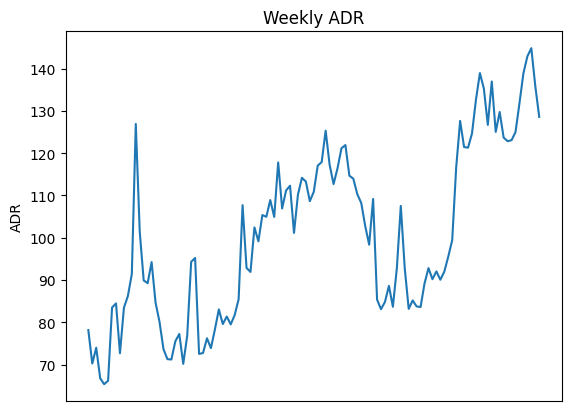

In [17]:
plt.plot(tseries)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('ADR')
plt.title("Weekly ADR")
plt.show()

In [18]:
df=pd.DataFrame(tseries)
df

,ADR
FullDate,
201527,78.165879
201528,70.247336
201529,73.996534
201530,66.766446
201531,65.363578
...,...
201731,138.898408
201732,142.909221
201733,144.839923


In [19]:
df.to_csv("weekly adr h2.csv", sep='\t', encoding='utf-8')

In [20]:
df = df[:100]

In [21]:
df

,ADR
FullDate,
201527,78.165879
201528,70.247336
201529,73.996534
201530,66.766446
201531,65.363578
...,...
201716,121.461748
201717,121.316925
201718,124.661435


In [22]:
df=np.array(df)

### Training and Validation data partition

In [23]:
train_size = int(len(df) * 0.8)
val_size = len(df) - train_size
train, val = df[0:train_size,:], df[train_size:len(df),:]

### Form dataset matrix

In [24]:
def create_dataset(df, previous=1):
    dataX, dataY = [], []
    for i in range(len(df)-previous-1):
        a = df[i:(i+previous), 0]
        dataX.append(a)
        dataY.append(df[i + previous, 0])
    return np.array(dataX), np.array(dataY)

In [25]:
df

array([[ 78.16587912],
       [ 70.24733645],
       [ 73.99653409],
       [ 66.76644592],
       [ 65.36357759],
       [ 66.19251773],
       [ 83.49771567],
       [ 84.47268398],
       [ 72.68456522],
       [ 83.45116535],
       [ 86.20366422],
       [ 91.45293608],
       [126.92589397],
       [101.41107955],
       [ 89.9096928 ],
       [ 89.26574257],
       [ 94.24644567],
       [ 84.64276423],
       [ 80.10729242],
       [ 73.66123894],
       [ 71.29099688],
       [ 71.20313158],
       [ 75.51997732],
       [ 77.24792627],
       [ 70.17713287],
       [ 76.81377451],
       [ 94.30473002],
       [ 95.21253521],
       [ 72.52884422],
       [ 72.73885106],
       [ 76.22860526],
       [ 73.89953608],
       [ 78.31005495],
       [ 83.05294239],
       [ 79.5900545 ],
       [ 81.36655536],
       [ 79.51510608],
       [ 81.69887067],
       [ 85.45253049],
       [107.70945312],
       [ 92.86574132],
       [ 91.91686905],
       [102.45118665],
       [ 99

## Normalize dataset with MinMaxScaler

In [26]:
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
train

array([[0.20795679],
       [0.07933033],
       [0.14023118],
       [0.02278778],
       [0.        ],
       [0.01346506],
       [0.29456556],
       [0.31040265],
       [0.11891995],
       [0.29380941],
       [0.33852018],
       [0.4237878 ],
       [1.        ],
       [0.58554493],
       [0.39871981],
       [0.38825968],
       [0.46916474],
       [0.31316539],
       [0.23949253],
       [0.13478475],
       [0.09628324],
       [0.09485598],
       [0.16497754],
       [0.19304583],
       [0.07818996],
       [0.1859936 ],
       [0.47011149],
       [0.48485761],
       [0.11639047],
       [0.11980175],
       [0.17648829],
       [0.13865558],
       [0.21029874],
       [0.28734079],
       [0.23109067],
       [0.25994762],
       [0.22987323],
       [0.26534565],
       [0.32631899],
       [0.68785384],
       [0.44673699],
       [0.43132379],
       [0.60244012],
       [0.54894409],
       [0.64998361],
       [0.64319663],
       [0.70748455],
       [0.642

In [27]:
val = scaler.fit_transform(val)
val

array([[0.17175584],
       [0.        ],
       [0.03578306],
       [0.01032308],
       [0.00809862],
       [0.1079319 ],
       [0.17290013],
       [0.12595784],
       [0.15895961],
       [0.1235353 ],
       [0.15807057],
       [0.22151887],
       [0.29161135],
       [0.59890005],
       [0.79709186],
       [0.68629491],
       [0.68369873],
       [0.74365417],
       [0.88667337],
       [1.        ]])

## Configure LSTM model

In [28]:
# Lookback period
lookback = 5
X_train, Y_train = create_dataset(train, lookback)
X_val, Y_val = create_dataset(val, lookback)

In [29]:
X_train

array([[0.20795679, 0.07933033, 0.14023118, 0.02278778, 0.        ],
       [0.07933033, 0.14023118, 0.02278778, 0.        , 0.01346506],
       [0.14023118, 0.02278778, 0.        , 0.01346506, 0.29456556],
       [0.02278778, 0.        , 0.01346506, 0.29456556, 0.31040265],
       [0.        , 0.01346506, 0.29456556, 0.31040265, 0.11891995],
       [0.01346506, 0.29456556, 0.31040265, 0.11891995, 0.29380941],
       [0.29456556, 0.31040265, 0.11891995, 0.29380941, 0.33852018],
       [0.31040265, 0.11891995, 0.29380941, 0.33852018, 0.4237878 ],
       [0.11891995, 0.29380941, 0.33852018, 0.4237878 , 1.        ],
       [0.29380941, 0.33852018, 0.4237878 , 1.        , 0.58554493],
       [0.33852018, 0.4237878 , 1.        , 0.58554493, 0.39871981],
       [0.4237878 , 1.        , 0.58554493, 0.39871981, 0.38825968],
       [1.        , 0.58554493, 0.39871981, 0.38825968, 0.46916474],
       [0.58554493, 0.39871981, 0.38825968, 0.46916474, 0.31316539],
       [0.39871981, 0.38825968, 0.

In [30]:
Y_train

array([0.01346506, 0.29456556, 0.31040265, 0.11891995, 0.29380941,
       0.33852018, 0.4237878 , 1.        , 0.58554493, 0.39871981,
       0.38825968, 0.46916474, 0.31316539, 0.23949253, 0.13478475,
       0.09628324, 0.09485598, 0.16497754, 0.19304583, 0.07818996,
       0.1859936 , 0.47011149, 0.48485761, 0.11639047, 0.11980175,
       0.17648829, 0.13865558, 0.21029874, 0.28734079, 0.23109067,
       0.25994762, 0.22987323, 0.26534565, 0.32631899, 0.68785384,
       0.44673699, 0.43132379, 0.60244012, 0.54894409, 0.64998361,
       0.64319663, 0.70748455, 0.64285672, 0.85207922, 0.67514459,
       0.74433749, 0.76267414, 0.58138821, 0.72872326, 0.7930007 ,
       0.77851656, 0.70323679, 0.7393136 , 0.83980916, 0.85343631,
       0.9741984 , 0.8437535 , 0.76887505, 0.82939327, 0.90660036,
       0.9187816 , 0.80115282, 0.78953003, 0.73009895, 0.69643783,
       0.60814505, 0.5361015 , 0.71180524, 0.32517525, 0.28813093,
       0.31633414, 0.37780986, 0.29748547, 0.44533731])

Epoch 1/100


2023-04-16 21:15:36.429403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-16 21:15:36.431313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-16 21:15:36.432704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

59/59 - 2s - loss: 0.4469 - val_loss: 0.5521 - 2s/epoch - 39ms/step


2023-04-16 21:15:38.710400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-16 21:15:38.712050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-16 21:15:38.713340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 2/100
59/59 - 0s - loss: 0.2975 - val_loss: 0.3733 - 121ms/epoch - 2ms/step
Epoch 3/100
59/59 - 0s - loss: 0.2018 - val_loss: 0.2433 - 132ms/epoch - 2ms/step
Epoch 4/100
59/59 - 0s - loss: 0.1387 - val_loss: 0.1633 - 144ms/epoch - 2ms/step
Epoch 5/100
59/59 - 0s - loss: 0.0982 - val_loss: 0.1132 - 118ms/epoch - 2ms/step
Epoch 6/100
59/59 - 0s - loss: 0.0742 - val_loss: 0.0778 - 133ms/epoch - 2ms/step
Epoch 7/100
59/59 - 0s - loss: 0.0603 - val_loss: 0.0574 - 138ms/epoch - 2ms/step
Epoch 8/100
59/59 - 0s - loss: 0.0527 - val_loss: 0.0462 - 117ms/epoch - 2ms/step
Epoch 9/100
59/59 - 0s - loss: 0.0484 - val_loss: 0.0391 - 124ms/epoch - 2ms/step
Epoch 10/100
59/59 - 0s - loss: 0.0457 - val_loss: 0.0342 - 121ms/epoch - 2ms/step
Epoch 11/100
59/59 - 0s - loss: 0.0439 - val_loss: 0.0330 - 125ms/epoch - 2ms/step
Epoch 12/100
59/59 - 0s - loss: 0.0420 - val_loss: 0.0291 - 132ms/epoch - 2ms/step
Epoch 13/100
59/59 - 0s - loss: 0.0398 - val_loss: 0.0282 - 118ms/epoch - 2ms/step
Epoch 14/100

dict_keys(['loss', 'val_loss'])


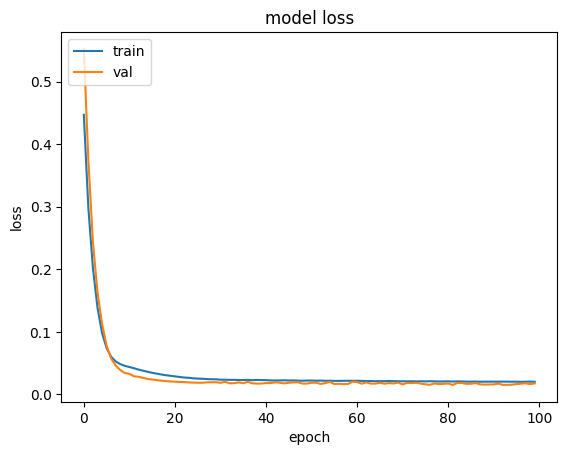

In [31]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

# Generate LSTM network
model = tf.keras.Sequential()
model.add(LSTM(4, input_shape=(1, lookback)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=1, verbose=2)


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
# Generate predictions
trainpred = model.predict(X_train)
valpred = model.predict(X_val)

3/3 [==============================] - 0s 2ms/step


2023-04-16 21:15:51.743909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-16 21:15:51.745600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-16 21:15:51.746849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 22ms/step


In [33]:
trainpred

array([[0.13448182],
       [0.14264086],
       [0.25433853],
       [0.29448974],
       [0.22100581],
       [0.2967385 ],
       [0.34261805],
       [0.39117938],
       [0.72484773],
       [0.5796111 ],
       [0.48499107],
       [0.47469634],
       [0.48729265],
       [0.38166553],
       [0.31547508],
       [0.24072972],
       [0.19225961],
       [0.18434028],
       [0.21365367],
       [0.23521091],
       [0.1905802 ],
       [0.22863646],
       [0.38241708],
       [0.42455214],
       [0.25141397],
       [0.22444573],
       [0.2349046 ],
       [0.20587572],
       [0.24440368],
       [0.2926034 ],
       [0.27539265],
       [0.29063463],
       [0.28205568],
       [0.2951479 ],
       [0.33288914],
       [0.5452118 ],
       [0.45748127],
       [0.45289457],
       [0.5772259 ],
       [0.559818  ],
       [0.6173181 ],
       [0.64100134],
       [0.6905118 ],
       [0.667616  ],
       [0.79102135],
       [0.7129882 ],
       [0.748492  ],
       [0.773

In [34]:
valpred

array([[0.13447247],
       [0.17970653],
       [0.21424595],
       [0.20533207],
       [0.22023796],
       [0.20817259],
       [0.21730721],
       [0.2521549 ],
       [0.29398796],
       [0.47061533],
       [0.63365746],
       [0.62917084],
       [0.677421  ],
       [0.74714327]], dtype=float32)

In [35]:
# Convert predictions back to normal values
trainpred = scaler.inverse_transform(trainpred)
Y_train = scaler.inverse_transform([Y_train])
valpred = scaler.inverse_transform(valpred)
Y_val = scaler.inverse_transform([Y_val])
predictions = valpred

In [36]:
Y_train.shape

(1, 74)

In [37]:
Y_val.shape

(1, 14)

In [38]:
X_train.shape

(74, 1, 5)

In [39]:
X_val.shape

(14, 1, 5)

In [40]:
Y_train

array([[ 83.92909653,  99.60980256, 100.49324761,  89.81171564,
         99.56762206, 102.06173543, 106.81824207, 138.96124481,
        115.84158413, 105.41986776, 104.83636712, 109.34951637,
        100.6473619 ,  96.53764872,  90.69670601,  88.54896583,
         88.46934871,  92.38095893,  93.94670002,  87.53966364,
         93.55330342, 109.40232939, 110.22491613,  89.67061265,
         89.86090551,  93.0230658 ,  90.91263347,  94.90912343,
         99.2067815 ,  96.0689655 ,  97.67870079,  96.00105272,
         97.97982065, 101.38111292, 121.5487101 , 108.09842297,
        107.23862423, 116.78405319, 113.7998699 , 119.43618489,
        119.05758489, 122.64377569, 119.03862377, 130.70973937,
        120.83974653, 124.69955307, 125.72243165, 115.60970908,
        123.82854048, 127.41414606, 126.60617371, 122.40682163,
        124.4193043 , 130.02527537, 130.78544243, 137.52194714,
        130.24530337, 126.06833859, 129.44424318, 133.75110723,
        134.43061673, 127.86889807, 127.

In [41]:
Y_val

array([[ 89.19876623,  92.82290682,  90.20431193,  92.04525896,
         90.06917483,  91.99566508,  95.53501946,  99.44500705,
        116.58657688, 127.64236479, 121.46174792, 121.31692451,
        124.66143536, 132.63951467]])

In [42]:
X_train

array([[[0.20795679, 0.07933033, 0.14023118, 0.02278778, 0.        ]],

       [[0.07933033, 0.14023118, 0.02278778, 0.        , 0.01346506]],

       [[0.14023118, 0.02278778, 0.        , 0.01346506, 0.29456556]],

       [[0.02278778, 0.        , 0.01346506, 0.29456556, 0.31040265]],

       [[0.        , 0.01346506, 0.29456556, 0.31040265, 0.11891995]],

       [[0.01346506, 0.29456556, 0.31040265, 0.11891995, 0.29380941]],

       [[0.29456556, 0.31040265, 0.11891995, 0.29380941, 0.33852018]],

       [[0.31040265, 0.11891995, 0.29380941, 0.33852018, 0.4237878 ]],

       [[0.11891995, 0.29380941, 0.33852018, 0.4237878 , 1.        ]],

       [[0.29380941, 0.33852018, 0.4237878 , 1.        , 0.58554493]],

       [[0.33852018, 0.4237878 , 1.        , 0.58554493, 0.39871981]],

       [[0.4237878 , 1.        , 0.58554493, 0.39871981, 0.38825968]],

       [[1.        , 0.58554493, 0.39871981, 0.38825968, 0.46916474]],

       [[0.58554493, 0.39871981, 0.38825968, 0.46916474, 0.31316

In [43]:
X_val

array([[[0.17175584, 0.        , 0.03578306, 0.01032308, 0.00809862]],

       [[0.        , 0.03578306, 0.01032308, 0.00809862, 0.1079319 ]],

       [[0.03578306, 0.01032308, 0.00809862, 0.1079319 , 0.17290013]],

       [[0.01032308, 0.00809862, 0.1079319 , 0.17290013, 0.12595784]],

       [[0.00809862, 0.1079319 , 0.17290013, 0.12595784, 0.15895961]],

       [[0.1079319 , 0.17290013, 0.12595784, 0.15895961, 0.1235353 ]],

       [[0.17290013, 0.12595784, 0.15895961, 0.1235353 , 0.15807057]],

       [[0.12595784, 0.15895961, 0.1235353 , 0.15807057, 0.22151887]],

       [[0.15895961, 0.1235353 , 0.15807057, 0.22151887, 0.29161135]],

       [[0.1235353 , 0.15807057, 0.22151887, 0.29161135, 0.59890005]],

       [[0.15807057, 0.22151887, 0.29161135, 0.59890005, 0.79709186]],

       [[0.22151887, 0.29161135, 0.59890005, 0.79709186, 0.68629491]],

       [[0.29161135, 0.59890005, 0.79709186, 0.68629491, 0.68369873]],

       [[0.59890005, 0.79709186, 0.68629491, 0.68369873, 0.74365

In [44]:
# calculate RMSE
trainScore = math.sqrt(mean_squared_error(Y_train[0], trainpred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = math.sqrt(mean_squared_error(Y_val[0], valpred[:,0]))
print('Validation Score: %.2f RMSE' % (valScore))

Train Score: 7.78 RMSE
Validation Score: 7.50 RMSE


In [45]:
# Train predictions
trainpredPlot = np.empty_like(df)
trainpredPlot[:, :] = np.nan
trainpredPlot[lookback:len(trainpred)+lookback, :] = trainpred

In [46]:
# Validation predictions
valpredPlot = np.empty_like(df)
valpredPlot[:, :] = np.nan
valpredPlot[len(trainpred)+(lookback*2)+1:len(df)-1, :] = valpred

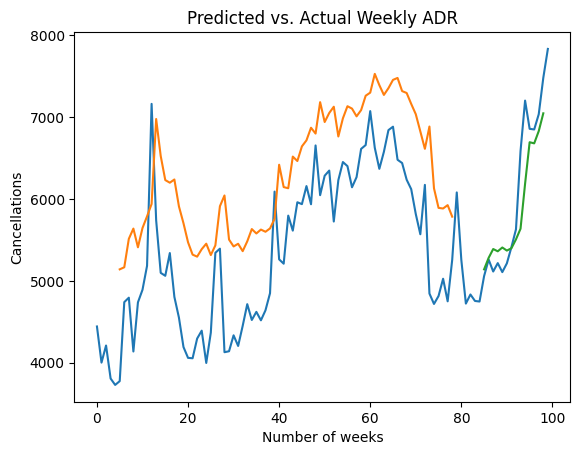

In [47]:
# Plot all predictions
inversetransform, =plt.plot(scaler.inverse_transform(df))
trainpred, =plt.plot(scaler.inverse_transform(trainpredPlot))
valpred, =plt.plot(scaler.inverse_transform(valpredPlot))
plt.xlabel('Number of weeks')
plt.ylabel('Cancellations')
plt.title("Predicted vs. Actual Weekly ADR")
plt.show()

In [48]:
Y_val=Y_val.reshape(-1)
Y_val.shape
Y_val=pd.Series(Y_val)

In [49]:
Y_val

0      89.198766
1      92.822907
2      90.204312
3      92.045259
4      90.069175
5      91.995665
6      95.535019
7      99.445007
8     116.586577
9     127.642365
10    121.461748
11    121.316925
12    124.661435
13    132.639515
dtype: float64

In [50]:
np.mean(Y_val)

106.11604817801238

In [51]:
predictions=predictions.reshape(-1)
predictions.shape
predictions=pd.Series(predictions)

In [52]:
predictions

0      90.679283
1      93.202591
2      95.129311
3      94.632065
4      95.463562
5      94.790520
6      95.300079
7      97.243996
8      99.577583
9     109.430435
10    118.525467
11    118.275177
12    120.966728
13    124.856071
dtype: float32

In [53]:
import numpy as np

def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

In [54]:
mda(Y_val, predictions)

0.8571428571428571

In [55]:
# https://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python/

mse = mean_squared_error(Y_val, predictions)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 7.503240


In [56]:
forecast_error = (predictions-Y_val)
forecast_error

0      1.480517
1      0.379684
2      4.924999
3      2.586806
4      5.394387
5      2.794855
6     -0.234940
7     -2.201011
8    -17.008994
9    -18.211930
10    -2.936281
11    -3.041748
12    -3.694707
13    -7.783443
dtype: float64

In [57]:
mean_forecast_error = np.mean(forecast_error)
mean_forecast_error

-2.6822718675003663

In [58]:
X_train

array([[[0.20795679, 0.07933033, 0.14023118, 0.02278778, 0.        ]],

       [[0.07933033, 0.14023118, 0.02278778, 0.        , 0.01346506]],

       [[0.14023118, 0.02278778, 0.        , 0.01346506, 0.29456556]],

       [[0.02278778, 0.        , 0.01346506, 0.29456556, 0.31040265]],

       [[0.        , 0.01346506, 0.29456556, 0.31040265, 0.11891995]],

       [[0.01346506, 0.29456556, 0.31040265, 0.11891995, 0.29380941]],

       [[0.29456556, 0.31040265, 0.11891995, 0.29380941, 0.33852018]],

       [[0.31040265, 0.11891995, 0.29380941, 0.33852018, 0.4237878 ]],

       [[0.11891995, 0.29380941, 0.33852018, 0.4237878 , 1.        ]],

       [[0.29380941, 0.33852018, 0.4237878 , 1.        , 0.58554493]],

       [[0.33852018, 0.4237878 , 1.        , 0.58554493, 0.39871981]],

       [[0.4237878 , 1.        , 0.58554493, 0.39871981, 0.38825968]],

       [[1.        , 0.58554493, 0.39871981, 0.38825968, 0.46916474]],

       [[0.58554493, 0.39871981, 0.38825968, 0.46916474, 0.31316

In [59]:
X_train.shape

(74, 1, 5)

## Validate Predictions on Test Data

In [60]:
Xnew = np.array([tseries.iloc[95:100],tseries.iloc[96:101],tseries.iloc[97:102],tseries.iloc[98:103],tseries.iloc[99:104],tseries.iloc[100:105],tseries.iloc[101:106],tseries.iloc[102:107],tseries.iloc[103:108],tseries.iloc[104:109],tseries.iloc[105:110],tseries.iloc[106:111],tseries.iloc[107:112],tseries.iloc[108:113],tseries.iloc[109:114]])

In [61]:
Xnew

array([[121.46174792, 121.31692451, 124.66143536, 132.63951467,
        138.96124481],
       [121.31692451, 124.66143536, 132.63951467, 138.96124481,
        135.29018595],
       [124.66143536, 132.63951467, 138.96124481, 135.29018595,
        126.70549121],
       [132.63951467, 138.96124481, 135.29018595, 126.70549121,
        136.96731501],
       [138.96124481, 135.29018595, 126.70549121, 136.96731501,
        125.04368653],
       [135.29018595, 126.70549121, 136.96731501, 125.04368653,
        129.75435252],
       [126.70549121, 136.96731501, 125.04368653, 129.75435252,
        123.69777658],
       [136.96731501, 125.04368653, 129.75435252, 123.69777658,
        122.84483755],
       [125.04368653, 129.75435252, 123.69777658, 122.84483755,
        123.08675055],
       [129.75435252, 123.69777658, 122.84483755, 123.08675055,
        124.98114286],
       [123.69777658, 122.84483755, 123.08675055, 124.98114286,
        131.79458537],
       [122.84483755, 123.08675055, 124.981

In [62]:
Xnew = scaler.fit_transform(Xnew)
Xnew
Xnewformat = np.reshape(Xnew, (Xnew.shape[0], 1, Xnew.shape[1]))
ynew=model.predict(Xnewformat)

1/1 [==============================] - 0s 27ms/step


In [63]:
Xnew.shape

(15, 5)

In [64]:
ynew

array([[0.52464813],
       [0.51395726],
       [0.34187794],
       [0.5889067 ],
       [0.27370042],
       [0.33707428],
       [0.20963493],
       [0.10940319],
       [0.1413166 ],
       [0.15877014],
       [0.32390678],
       [0.53882325],
       [0.7124076 ],
       [0.86338484],
       [0.73773444]], dtype=float32)

In [65]:
type(ynew)

numpy.ndarray

In [66]:
ynew.shape

(15, 1)

In [67]:
actual = tseries.iloc[100:115]
actual

FullDate
201721    135.290186
201722    126.705491
201723    136.967315
201724    125.043687
201725    129.754353
201726    123.697777
201727    122.844838
201728    123.086751
201729    124.981143
201730    131.794585
201731    138.898408
201732    142.909221
201733    144.839923
201734    135.892708
201735    128.586952
Name: ADR, dtype: float64

In [68]:
actual = np.array(actual)
actual

array([135.29018595, 126.70549121, 136.96731501, 125.04368653,
       129.75435252, 123.69777658, 122.84483755, 123.08675055,
       124.98114286, 131.79458537, 138.89840845, 142.90922096,
       144.83992318, 135.89270833, 128.58695175])

In [69]:
actual=actual.reshape(15,-1)
actual.shape

(15, 1)

In [70]:
actual

array([[135.29018595],
       [126.70549121],
       [136.96731501],
       [125.04368653],
       [129.75435252],
       [123.69777658],
       [122.84483755],
       [123.08675055],
       [124.98114286],
       [131.79458537],
       [138.89840845],
       [142.90922096],
       [144.83992318],
       [135.89270833],
       [128.58695175]])

In [71]:
ynew=ynew.reshape(-1)
actual=actual.reshape(-1)
actualpd=pd.Series(actual)

In [72]:
np.min(df)

65.3635775862069

In [73]:
ynew

array([0.52464813, 0.51395726, 0.34187794, 0.5889067 , 0.27370042,
       0.33707428, 0.20963493, 0.10940319, 0.1413166 , 0.15877014,
       0.32390678, 0.53882325, 0.7124076 , 0.86338484, 0.73773444],
      dtype=float32)

In [74]:
maxt=np.max(tseries)

In [75]:
mint=np.min(tseries)

In [76]:
ynew = ynew * np.abs(maxt-mint) + np.min(tseries)
ynewpd=pd.Series(ynew)

In [77]:
actualpd

0     135.290186
1     126.705491
2     136.967315
3     125.043687
4     129.754353
5     123.697777
6     122.844838
7     123.086751
8     124.981143
9     131.794585
10    138.898408
11    142.909221
12    144.839923
13    135.892708
14    128.586952
dtype: float64

In [78]:
ynewpd

0     107.060699
1     106.211029
2      92.534790
3     112.167732
4      87.116287
5      92.153015
6      82.024597
7      74.058548
8      76.594910
9      77.982048
10     91.106506
11    108.187286
12    121.983131
13    133.982254
14    123.996017
dtype: float32

In [79]:
mda(actualpd, ynewpd)

0.8666666666666667

In [80]:
mse = mean_squared_error(actualpd, ynewpd)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 36.068411


In [81]:
forecast_error = (ynewpd-actualpd)
forecast_error

0    -28.229486
1    -20.494462
2    -44.432525
3    -12.875954
4    -42.638065
5    -31.544761
6    -40.820240
7    -49.028203
8    -48.386233
9    -53.812537
10   -47.791902
11   -34.721935
12   -22.856792
13    -1.910454
14    -4.590934
dtype: float64

In [82]:
mean_forecast_error = np.mean(forecast_error)
mean_forecast_error

-32.27563234507184

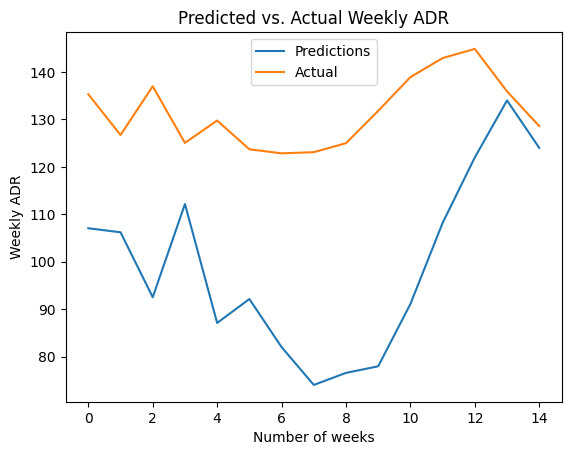

In [83]:
predictons, =plt.plot(ynewpd, label='Predictions')
actual, =plt.plot(actualpd, label='Actual')
plt.xlabel('Number of weeks')
plt.ylabel('Weekly ADR')
plt.title("Predicted vs. Actual Weekly ADR")
plt.legend(loc = 'upper center')
plt.show()

In [84]:
np.mean(actualpd)

131.41955578664087